In [2]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron
from sklearn.utils import shuffle
from sklearn.datasets import load_digits

# Libraries for modifying data
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate

# Librairies for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


## ResNet

#### Imports & Dataset preparation

##### Digits Data

In [ ]:
class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (N, 1, 8, 8)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# load the digits dataset
digits = load_digits()
X = digits.images / 16.0  # normalize [0, 1]
y = digits.target

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = DigitsDataset(X_train, y_train)
test_dataset = DigitsDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


##### Digits Augmented

In [ ]:
class DigitsFromCSV(Dataset):
    def __init__(self, dataframe):
        X = dataframe.drop(columns=["label"]).values
        y = dataframe["label"].values

        self.X = torch.tensor(X.reshape(-1, 1, 8, 8), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
# Path to the csv file
df = pd.read_csv("data/augmented_data/digits_rotated.csv")

# Normalization: scale pixel values to [0, 1]
df.iloc[:, :-1] = df.iloc[:, :-1] / 16.0

# Split train / test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = DigitsFromCSV(df_train)
test_dataset = DigitsFromCSV(df_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


##### MNIST Data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

##### MNIST Gaussian Noise

In [3]:
class AddGaussianNoise:
    def __init__(self, noise_level=0.5):
        self.noise_level = noise_level

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Image tensor of shape (1, 28, 28) with values in [0, 1]
        Returns:
            torch.Tensor: Noisy image tensor, still in [0, 1]
        """
        noise = torch.randn(tensor.size()) * self.noise_level
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)

In [4]:
# Define transform pipeline
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(noise_level=0.3)
])

# Load dataset MNIST with noise
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_with_noise)

# Dataset test without noise
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

##### MNIST Impulse Noise

In [ ]:
class AddImpulseNoise:
    def __init__(self, probability=0.05):
        """
        Args:
            probability (float): Proportion of pixels to be replaced by 0 or 1 (default = 5%)
        """
        self.probability = probability

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Image tensor of shape (1, 28, 28) with values in [0, 1]
        Returns:
            torch.Tensor: Noisy image tensor with impulse noise
        """
        noisy_tensor = tensor.clone()
        mask = torch.rand_like(tensor)

        # Apply salt (1) where mask < p/2, and pepper (0) where mask > 1 - p/2
        noisy_tensor[mask < self.probability / 2] = 0.0
        noisy_tensor[mask > 1 - self.probability / 2] = 1.0

        return noisy_tensor


In [ ]:
# Define transform pipeline
transform_with_impulse_noise = transforms.Compose([
    transforms.ToTensor(),
    AddImpulseNoise(probability=0.05)  # tu peux augmenter la probabilité si besoin
])

# Load dataset MNIST with impulse noise
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_with_impulse_noise)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


### Mini ResNet

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.residual = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.residual(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# Mini-ResNet
class MiniResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.layer1 = ResidualBlock(16, 32, downsample=True)
        self.layer2 = ResidualBlock(32, 32)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.fc(x)


#### Training

In [6]:
model = MiniResNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 835.8465
Epoch 2 - Loss: 198.7124
Epoch 3 - Loss: 147.7141


#### Evaluation

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch).argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.54%


#### View some predictions

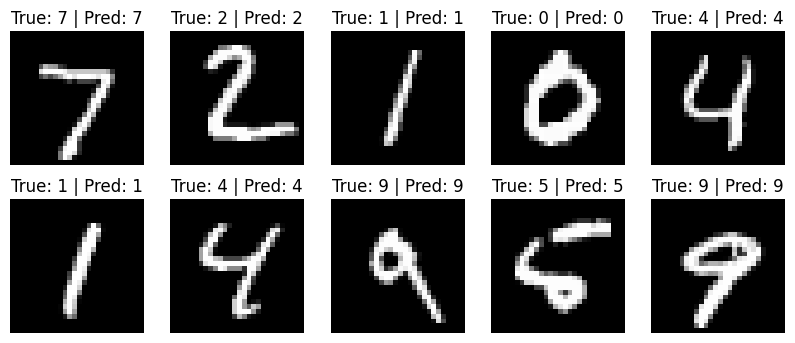

In [8]:
model.eval()
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

with torch.no_grad():
    for i in range(10):
        image, label = test_dataset[i]
        output = model(image.unsqueeze(0)).argmax().item()
        ax = axs[i // 5, i % 5]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"True: {label} | Pred: {output}")
        ax.axis("off")
plt.show()
